In [54]:
# imports
from refexps import move_level, get_previous, load_data, extract_info

import pickle
from os import listdir

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

%matplotlib inline

In [55]:
#current: [((a_m, z_m), {speaker: {obj: {type: [(exp, (a_e, z_e), cat)]}}})]
#previously: {(start_i, end_i):{speaker:{obj_id:{ref_type:[refs_exp_ls]}}}}

#bigram construction
corpus = 'Push_to_Talk_Corpus'

# [PTT_data, FTT_data]
dataset = [[], []]
for name in listdir('Dataset/'+ corpus +'/RefExp/'):
    with open("Dataset/"+ corpus +"/RefExp/" + name) as handle:
        d = pickle.load(handle)
        condition = 0 if name.startswith('PTT') else 1
        dataset[condition].append(d)
        
move_lvl_dataset = [[move_level(d) for d in cond] for cond in dataset]
        
all_prevs = [[(exp, get_previous(exp, ref_obj_exp_ls)) for d in cond for move_span, obj_dict in d 
                                        for ref_obj_exp_ls in obj_dict.values() for exp in ref_obj_exp_ls] 
                                             for cond in move_lvl_dataset]

get_exp_len = lambda exp_tup: exp_tup[0][1] - exp_tup[0][0] +1

all_prevs_lens = [[(get_exp_len(exp), get_exp_len(prev_exp)) for exp, prev_exp in cond if not prev_exp == 'no_previous']
                                                              for cond in all_prevs]



In [56]:
# per-move bigram construction
per_move_prevs = [{move_span: [(exp, get_previous(exp, ref_obj_exp_ls)) 
              for ref_obj_exp_ls in obj_dict.values() for exp in ref_obj_exp_ls] for d in cond 
                  for move_span, obj_dict in d} for cond in move_lvl_dataset]

print per_move_prevs[0].items()[0]

get_exp_len = lambda exp_tup: exp_tup[0][1] - exp_tup[0][0] + 1

per_move_prevs_lens = [{move_span: [(get_exp_len(exp), get_exp_len(prev_exp)) 
                                   for exp, prev_exp in exp_ls if not prev_exp == 'no_previous'] 
                      for move_span, exp_ls in cond.iteritems()} for cond in per_move_prevs]

per_move_num_pairs = [[len(ls) for ls in cond.values()] for cond in per_move_prevs_lens]

((1, 108), [(((51, 52), 'p-utts', 'ein z', 'indef_np'), 'no_previous'), (((51, 52), 'p-utts', 'ein z', 'indef_np'), 'no_previous'), (((56, 57), 'e-utts', "'n z", 'indef_np'), ((51, 52), 'p-utts', 'ein z', 'indef_np')), (((51, 52), 'p-utts', 'ein z', 'indef_np'), 'no_previous'), (((51, 52), 'p-utts', 'ein z', 'indef_np'), 'no_previous')])


In [67]:
#per-move stats on number of (expression, previous expression)-pairs

print 'PTT+FTT:'
print 'Total number of pairs:', sum(sum(ls for ls in cond) for cond in per_move_num_pairs)
print 'Per-move mean number of pairs:', np.mean(per_move_num_pairs[0]+per_move_num_pairs[1])
print '\tstd_dev:', np.var(per_move_num_pairs[0]+per_move_num_pairs[1])**.5
print 'Moves with no pair:', sum(len([n for n in cond if not n]) for cond in per_move_num_pairs)
print 'Moves with one pair:', sum(len([n for n in cond if n == 1]) for cond in per_move_num_pairs)
print '\tout of moves:', sum(len(cond) for cond in per_move_num_pairs)
print '--------'
print 'PTT:'
print 'Total number of pairs:', sum(ls for ls in per_move_num_pairs[0])
print 'Per-move mean number of pairs:', np.mean(per_move_num_pairs[0])
print '\tstd_dev:', np.var(per_move_num_pairs[0])**.5
print 'Moves with no pair:', len([n for n in per_move_num_pairs[0] if not n])
print 'Moves with one pair:', len([n for n in per_move_num_pairs[0] if n == 1])
print '\tout of moves:', len(per_move_num_pairs[0])
print '--------'
print 'FTT:'
print 'Total number of pairs:', sum(ls for ls in per_move_num_pairs[1])
print 'Per-move mean number of pairs:', np.mean(per_move_num_pairs[1])
print '\tstd_dev:', np.var(per_move_num_pairs[1])**.5
print 'Moves with no pair:', len([n for n in per_move_num_pairs[1] if not n])
print 'Moves with one pair:', len([n for n in per_move_num_pairs[1] if n == 1])
print '\tout of moves:', len(per_move_num_pairs[1])

 PTT+FTT:
Total number of pairs: 701
Per-move mean number of pairs: 3.04782608696
	std_dev: 4.71006042288
Moves with no pair: 85
Moves with one pair: 43
	out of moves: 230
--------
PTT:
Total number of pairs: 279
Per-move mean number of pairs: 2.90625
	std_dev: 4.04422975001
Moves with no pair: 36
Moves with one pair: 16
	out of moves: 96
--------
FTT:
Total number of pairs: 422
Per-move mean number of pairs: 3.14925373134
	std_dev: 5.13185466268
Moves with no pair: 49
Moves with one pair: 27
	out of moves: 134


In [58]:
# metric of coherence in length of expression and previous - construction

coh_metric = lambda e, prev_e: float(e - prev_e)/(e + prev_e)

per_move_coh_metrics = [{move_span: [round(coh_metric(exp, prev_exp), 4) for exp, prev_exp in exp_ls] 
                      for move_span, exp_ls in cond.iteritems()} for cond in per_move_prevs_lens]

metric_vals = [[m for metric_ls in cond.values() for m in metric_ls] for cond in per_move_coh_metrics]

PTT:


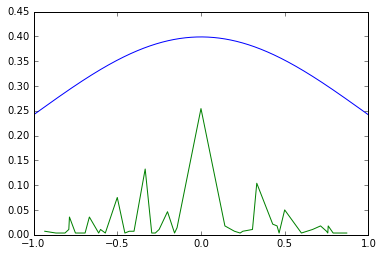

Skewedness of value distribution: -0.121863799283
	[negative value ~ previous expression longer]

FTT:


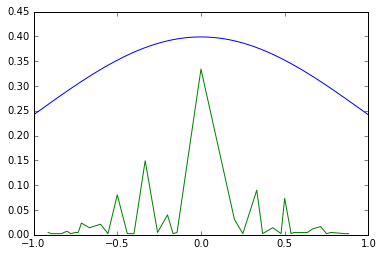

Skewedness of value distribution: -0.116113744076
	[negative value ~ previous expression longer]


In [65]:
# metric of coherence in length of expression and previous - stats

metric_vals_counts = [Counter(cond) for cond in metric_vals]

for i, cond in enumerate(metric_vals_counts):
    print 'PTT:' if i == 0 else '\nFTT:'
    x_axis = np.arange(-1, 1, 0.0001)
    plt.plot(x_axis, norm.pdf(x_axis,0,1))
    num_vals = sum(cond.values())
    val_probs = {val: float(val_count)/num_vals for val, val_count in cond.iteritems()}
    plt.plot(*list(zip(*sorted(val_probs.iteritems()))))
    plt.axis([-1, 1, 0, .45])
    plt.show()

    # skewedness
    neg_val_mass = sum([val_prob for val, val_prob in val_probs.iteritems() if val < 0])
    pos_val_mass = sum([val_prob for val, val_prob in val_probs.iteritems() if val > 0])
    print 'Skewedness of value distribution:', pos_val_mass - neg_val_mass
    print '\t[negative value ~ previous expression longer]'